The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [274]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

# Set display options to limit the number of rows shown in pandas output
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


In [236]:
df = pd.read_csv('AB_Test_Results.csv')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [237]:
df.columns = ['user_id', 'variant_name', 'revenue']

In [238]:
df.user_id = df.user_id.astype(str)

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       10000 non-null  object 
 1   variant_name  10000 non-null  object 
 2   revenue       10000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 234.5+ KB


In [240]:
df.describe()

,revenue
count,10000.000000
mean,0.099447
std,2.318529
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,196.010000


In [241]:
df.describe(include='object')

,user_id,variant_name
count,10000,10000
unique,6324,2
top,4879,variant
freq,6,5016


Let's see if there are users who have two A/B test groups

In [242]:
df.variant_name.value_counts()

variant_name
variant    5016
control    4984
Name: count, dtype: int64

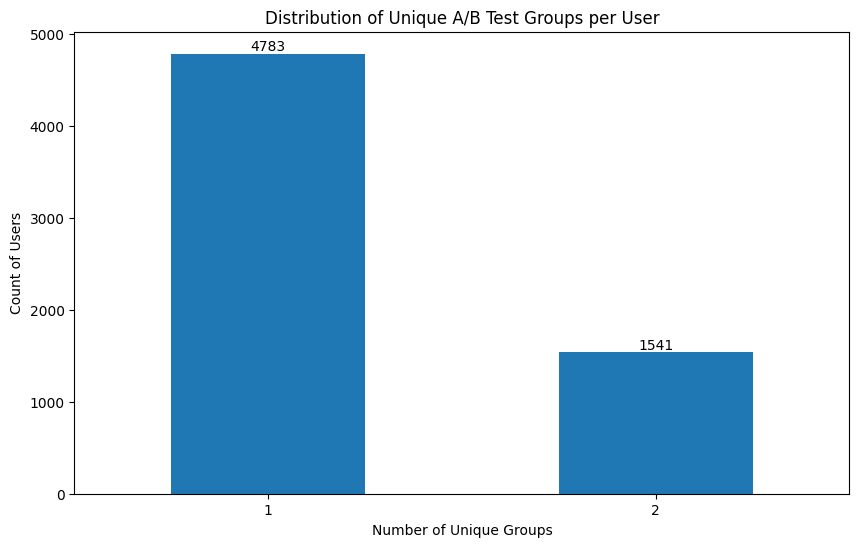

In [243]:
user_group_counts = df.groupby('user_id')['variant_name'].nunique()


plt.figure(figsize=(10, 6))
counts = user_group_counts.value_counts().sort_index()
ax = counts.plot(kind='bar')
plt.title('Distribution of Unique A/B Test Groups per User')
plt.xlabel('Number of Unique Groups')
plt.ylabel('Count of Users')
plt.xticks(rotation=0)

for i, v in enumerate(counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.show()


In [244]:
user_both_groups = user_group_counts[user_group_counts > 1]
print(f'Persentage of users in both categories: {float(len(user_both_groups) / len(user_group_counts)) * 100:.2f} %')

Persentage of users in both categories: 24.37 %


What can you observe ? Should we exclude these users ? Why ?

In [245]:
df_old = df.copy()

In [246]:
df = df[~((df.user_id.isin(user_both_groups.index)) & (df.variant_name == 'variant'))]
df

,user_id,variant_name,revenue
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9994,3129,control,0.0
9995,1981,control,0.0
9996,502,variant,0.0
9998,7741,control,0.0


In [247]:
df.user_id.nunique() ==  df_old.user_id.nunique()

True

In [248]:
df.variant_name.value_counts()

variant_name
control    4984
variant    3044
Name: count, dtype: int64

Let's see how the data is distributed

In [249]:
df.describe()

,revenue
count,8028.000000
mean,0.102431
std,2.415657
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,196.010000


In [250]:
print(f'Percentage of observations with 0 revenue: {(df.revenue == 0).mean() * 100:.2f} % ({(df.revenue == 0).sum()})')

Percentage of observations with 0 revenue: 98.47 % (7905)


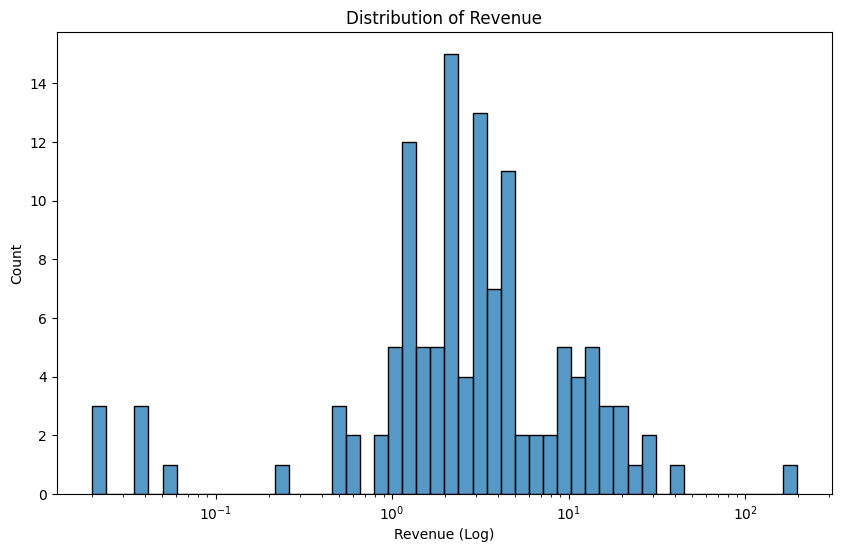

In [251]:
plt.figure(figsize=(10, 6))
sns.histplot(df.loc[df.revenue > 0, 'revenue'], bins=50, log_scale=True)
plt.title('Distribution of Revenue')
plt.xlabel('Revenue (Log)')
plt.ylabel('Count')
plt.show()


It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [252]:
df.sort_values(by='revenue', ascending=False)

,user_id,variant_name,revenue
1437,3342,control,196.01
9421,6792,control,41.53
8168,2166,control,29.32
9125,831,control,25.98
2482,7356,variant,23.04
...,...,...,...
9994,3129,control,0.00
9995,1981,control,0.00
9996,502,variant,0.00
9998,7741,control,0.00


In [253]:
df[df.user_id == '3342']

,user_id,variant_name,revenue
1437,3342,control,196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

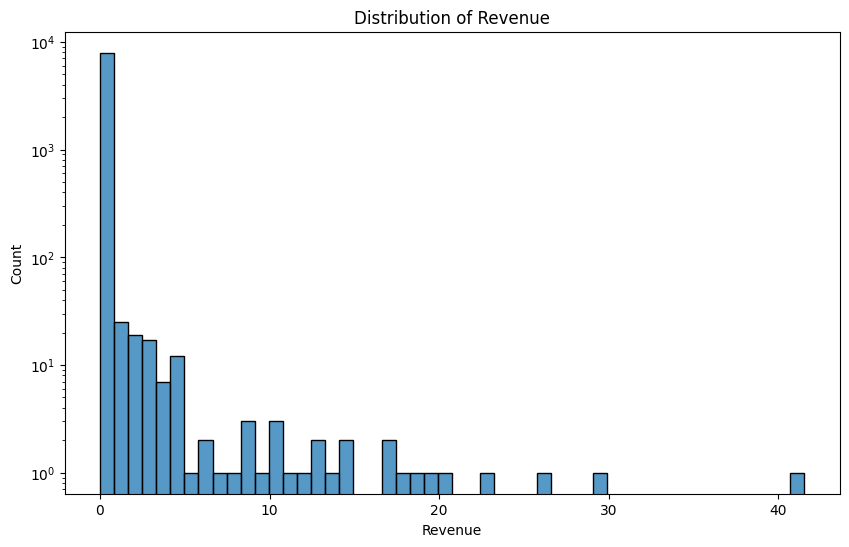

In [254]:
df = df[df.user_id != '3342']

plt.figure(figsize=(10, 6))
# sns.histplot(df.loc[df.revenue > 0, 'revenue'], bins=50)
sns.histplot(df['revenue'], bins=50)

plt.title('Distribution of Revenue')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.yscale('log') 
plt.show()


What can you say about the users and their purchases ?

In [313]:
statistics = [ 'mean', 'median', 'std', 'min', 'max', 'count', 'sum',
              lambda x: x.quantile(0.25), lambda x: x.quantile(0.5),
              lambda x: x.quantile(0.75), lambda x: x.skew(),
              lambda x: x.kurtosis()
]

statistics_name = ['mean', 'median', 'std', 'min', 'max', 'count', 'sum',
                   '25th quantile', '50th quantile', '75th quantile',
                   'skewness', 'kurtosis']


In [306]:
df[df.user_id.isin(df.user_id[df.revenue == 0]) & df.revenue > 0]

,user_id,variant_name,revenue


In [321]:
df[['revenue']].apply(lambda x: x.agg(statistics), axis=0).T

,mean,median,std,min,max,count,sum,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>
revenue,0.099053,0.0,1.156008,0.0,41.53,6323.0,626.31,0.0,0.0,0.0,19.200296,472.636946


Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [258]:
df = df.groupby(['user_id', 'variant_name'], as_index=False).sum()
df[df.user_id.isin(df.user_id[df.revenue == 0]) & df.revenue > 0]

,user_id,variant_name,revenue


In [259]:
print(f'Percentage of observations with 0 revenue: {(df.revenue == 0).mean() * 100:.2f} % ({(df.revenue == 0).sum()})')

Percentage of observations with 0 revenue: 98.09 % (6202)


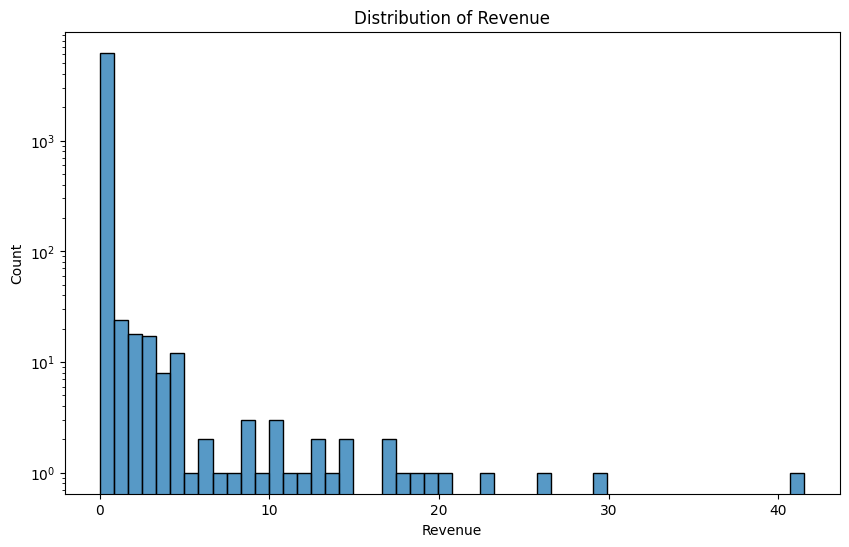

In [260]:
plt.figure(figsize=(10, 6))
sns.histplot(df['revenue'], bins=50)

plt.title('Distribution of Revenue')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.yscale('log') 
plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [261]:
df.variant_name.value_counts()

variant_name
control    3930
variant    2393
Name: count, dtype: int64

What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

In [308]:

get_df_stat(df.groupby('variant_name')['revenue'])

,mean,median,std,min,max,count,sum,25th quantile,50th quantile,75th quantile,skewness,kurtosis
variant_name,,,,,,,,,,,,
control,0.113738,0.0,1.304342,0.0,41.53,3930,446.99,0.0,0.0,0.0,18.393539,424.731352
variant,0.074935,0.0,0.858207,0.0,23.04,2393,179.32,0.0,0.0,0.0,17.875768,384.227460


Let's look at the distributions of all and only paying users

KeyError: 'VARIANT_NAME'

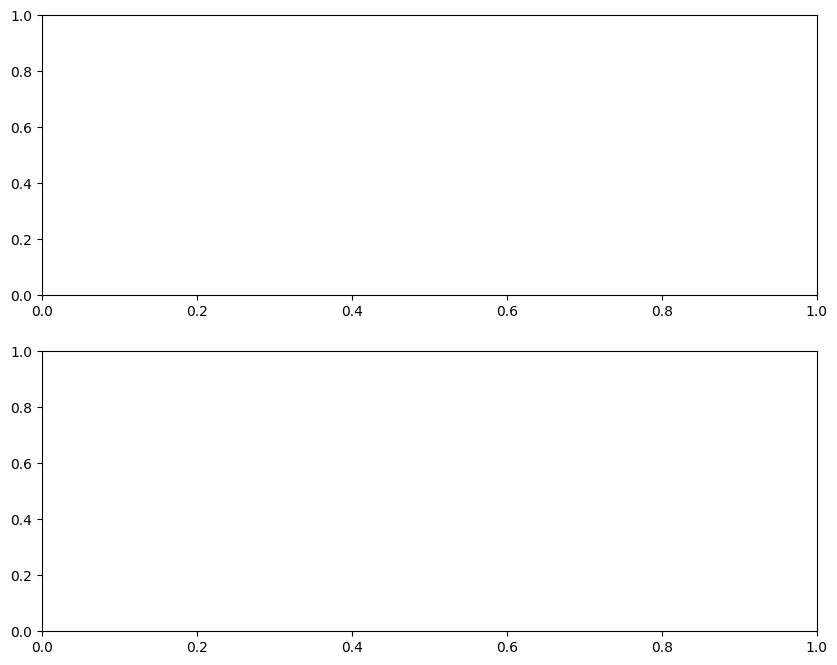

In [264]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [ ]:
# TODO : Use the Shapiro-Wilk criterion to confirm it

Is the null hypothesis about the normal distribution of the data rejected ?

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [ ]:
(df['REVENUE'] == 0).value_counts()

In [ ]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test

In [ ]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test

#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [ ]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
# TODO : Generate samples for all users

In [ ]:
# TODO : Generate samples for only paying users

Let's look at the distribution of means in the ab test groups

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [ ]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant, axis=1),
                                     np.mean(control, axis=1),
                                     title='all users')

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant_paid, axis=1),
                                     np.mean(control_paid, axis=1),
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.
